In [3]:
# ML imports
import torch
import torch.nn as nn
import torch.autograd as ag
import math

In [4]:
# Data reading imports
import h5py
import numpy as np

Ok bro it's time to test out 3D Matplotlib capabilities

In [5]:
# Graphing imports
from mpl_toolkits import mplot3d
# %matplotlib notebook
# kind of an L but it is what it is for goddamn colab
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

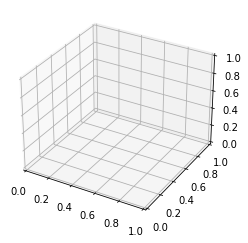

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')

In [7]:
# Read the labeled dataset info
f = h5py.File("depths.mat")

In [8]:
print(f.keys())

<KeysViewHDF5 ['#refs#', '#subsystem#', 'accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes']>


In [9]:
print(type(f["images"][0]))

<class 'numpy.ndarray'>


In [72]:
# Model setup (!!)
# Two models: One for depth, one for color constancy
# Then post-process and visualize accordingly
def convSize(orig, kernelSize, stride):
  return math.floor((orig - (kernelSize - 1) - 1)/stride + 1)

# This one takes in lists for kernelSize and stride
def repeatedConvSize(orig, kernelSize, stride):
  assert len(kernelSize) == len(stride), "bro the lists kernelSize and stride must be equal length"
  size = orig
  for i, k in enumerate(kernelSize):
    size = convSize(size, kernelSize[i], stride[i])
  return size

class DepthEstimator(nn.Module):
  """
  initialization notes:
  image_size is a tuple of the image size (W, H) (lol)
  """
  def __init__(self, image_size):
    # Image size of the nyu images is like 640x480, with 1449 examples
    # Might make the math for the linear layer a bit tricky
    super(DepthEstimator, self).__init__()
    self.image_size = image_size
    # Part 1: convolutional setup
    self.conv1 = nn.Conv2d(3, 6, 5) # Each image channel (R, G, B) is a separate layer
    self.conv2 = nn.Conv2d(6, 16, 5)
    # self.conv3 = nn.Conv2d(16, 32, 3)
    self.maxP1 = nn.MaxPool2d(4, 4, return_indices=True)
    self.maxP2 = nn.MaxPool2d(4, 4, return_indices=True)
    # self.maxP3 = nn.MaxPool2d(2, 2, return_indices=True)
    # self.linear_size = (
    #   repeatedConvSize(self.image_size[0], [5, 4, 5, 2, 3, 2], [1, 4, 1, 2, 1, 2]),
    #   repeatedConvSize(self.image_size[1], [5, 4, 5, 2, 3, 2], [1, 4, 1, 2, 1, 2])
    # )
    self.linear_size = (
      repeatedConvSize(self.image_size[0], [5, 4, 5, 4], [1, 4, 1, 4]),
      repeatedConvSize(self.image_size[1], [5, 4, 5, 4], [1, 4, 1, 4])
    )
    print(self.linear_size)
    self.fcIn = nn.Linear(16 * self.linear_size[0] * self.linear_size[1], 8 * self.linear_size[0] * self.linear_size[1]) # TODO: Make the numbers here
    # Part 2: And now starts the deconvolutional thingos
    self.fcOut = nn.Linear(8 * self.linear_size[0] * self.linear_size[1], 16 * self.linear_size[0] * self.linear_size[1])
    self.deconv1 = nn.ConvTranspose2d(16, 6, 5)
    self.deconv2 = nn.ConvTranspose2d(6, 1, 5)
    # self.deconv3 = nn.ConvTranspose2d(6, 1, 5)
    # self.unpool1 = nn.MaxUnpool2d(2, 2)
    self.unpool2 = nn.MaxUnpool2d(4, 4)
    self.unpool3 = nn.MaxUnpool2d(4, 4)
    self.relu = nn.ReLU()

  def forward(self, x):
    # print(type(x))
    x = self.conv1(x)
    self.preMaxP1 = x.size()
    x, ind1 = self.maxP1(x)
    # print(ind1.dtype)
    # print(torch.max(ind1), torch.min(ind1))

    x = self.conv2(x)
    self.preMaxP2 = x.size()
    x, ind2 = self.maxP2(x)

    # x = self.conv3(x)
    # self.preMaxP3 = x.size()
    # x, ind3 = self.maxP3(x)
    # print(ind1.shape, ind2.shape, ind3.shape)
    ogShape = tuple(x.shape)
    # print(ogShape)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = self.relu(self.fcIn(x))
    x = self.relu(self.fcOut(x))
    x = torch.reshape(x, ogShape)
    # print(x.dtype)
    x = self.deconv1(self.unpool2(x, ind2, output_size=self.preMaxP2))
    x = self.deconv2(self.unpool3(x, ind1, output_size=self.preMaxP1))
    # x = self.deconv3(self.unpool3(x, ind1, output_size=self.preMaxP1))
    return x

In [73]:
# Model training time
import torch.optim as optim

net = DepthEstimator((640, 480))

# Using SGD because yes!
optimizer = optim.SGD(net.parameters(), lr=0.005)
# Ok but we're gonna use like Least Squared Error as loss measurement probs

LeastSquaredLoss = nn.MSELoss()

VALIDATE_PARTITION = 500

# Code copied from the PyTorch tutorial & my NLP given hw lol
for e in range(10): # Number of epochs
  epochLoss = 0
  for i in range(VALIDATE_PARTITION):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(torch.unsqueeze(torch.Tensor(f["images"][i]), 0)/255) # TODO: Change input
    loss = LeastSquaredLoss(output, torch.Tensor(f["depths"][i]))
    loss.backward()
    optimizer.step()    # Does the update
    epochLoss += loss.item()
    if i % 50 == 0:
      print(i)
  epochLoss /= VALIDATE_PARTITION # placeholder, however large the training set it
  print("Epoch", e, "average loss:", epochLoss)

(3, 2)
0
50
100
150
200
250
300
350
400
450
Epoch 0 average loss: 3.140502363629639
0
50
100
150
200
250
300
350
400
450
Epoch 1 average loss: 2.361680042266846
0
50
100
150
200
250
300
350
400
450
Epoch 2 average loss: 2.3620613906532526
0
50
100
150
200
250
300
350
400
450
Epoch 3 average loss: 2.3620614783018827
0
50
100
150
200
250
300
350
400
450
Epoch 4 average loss: 2.362058790177107
0
50
100
150
200
250
300
350
400
450
Epoch 5 average loss: 2.3620561717301607
0
50
100
150
200
250
300
350
400
450
Epoch 6 average loss: 2.3620538221150635
0
50
100
150
200
250
300
350
400
450
Epoch 7 average loss: 2.362051399976015
0
50
100
150
200
250
300
350
400
450
Epoch 8 average loss: 2.362049047663808
0
50
100
150
200
250
300
350
400
450
Epoch 9 average loss: 2.3620468070060014


In [74]:
# Model testing time!
TEST_PARTITION = 1349
testLoss = 0
for i in range(TEST_PARTITION, 1449): # Placeholder for now, should loop through test set
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(torch.unsqueeze(torch.Tensor(f["images"][i]), 0)/255)
    loss = LeastSquaredLoss(output, torch.Tensor(f["depths"][i]))
    testLoss += loss.item()
testLoss /= (1449 - TEST_PARTITION) # however large the test set is
print("Test Loss (avg):", testLoss)

Test Loss (avg): 2.2899793277680875


In [75]:
IMAGE_EXAMPLE = 5

In [76]:
# Feed in sample image, get sample result!
# Show it in the mat of lab
output = net(torch.unsqueeze(torch.Tensor(f["images"][IMAGE_EXAMPLE]), 0)/255)
print(output)

tensor([[[[2.8402, 2.8402, 2.8402,  ..., 2.8402, 2.8402, 2.8402],
          [2.8402, 2.8402, 2.8402,  ..., 2.8402, 2.8402, 2.8402],
          [2.8402, 2.8402, 2.8402,  ..., 2.8402, 2.8402, 2.8402],
          ...,
          [2.8402, 2.8402, 2.8402,  ..., 2.8402, 2.8402, 2.8402],
          [2.8402, 2.8402, 2.8402,  ..., 2.8402, 2.8402, 2.8402],
          [2.8402, 2.8402, 2.8402,  ..., 2.8402, 2.8402, 2.8402]]]],
       grad_fn=<ConvolutionBackward0>)


0.008301107


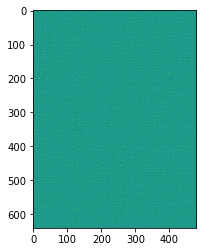

In [77]:
plt.imshow(np.squeeze(output.detach().numpy()))
print(np.std(np.squeeze(output.detach().numpy())))

0.799927


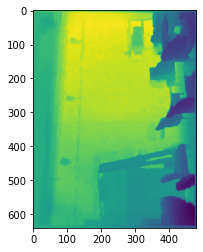

In [78]:
plt.imshow(f["depths"][IMAGE_EXAMPLE])
print(np.std(f["depths"][IMAGE_EXAMPLE]))

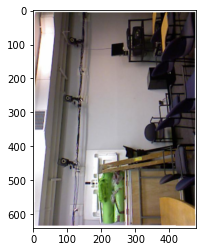

In [49]:
# plt.imshow(convertToMLPImg(f["images"][3]))
plt.imshow(np.moveaxis(f["images"][IMAGE_EXAMPLE], 0, -1))

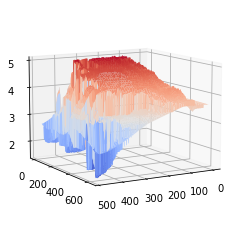

In [63]:
from matplotlib import cm

X = np.array([range(0, 480)])
Y = np.array([range(0, 640)])
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(elev=10., azim=60)
ax.plot_surface(X, Y, f["depths"][IMAGE_EXAMPLE], cmap=cm.coolwarm)

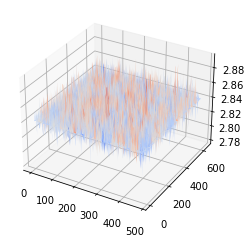

In [79]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, np.squeeze(output.detach().numpy()), cmap=cm.coolwarm)

Recorded losses for the best model:
(38, 28)
0
50
100
150
200
250
300
350
400
450
Epoch 0 average loss: 3.075797429703176
0
50
100
150
200
250
300
350
400
450
Epoch 1 average loss: 2.3616262866556643
0
50
100
150
200
250
300
350
400
450
Epoch 2 average loss: 2.3614280278235675
0
50
100
150
200
250
300
350
400
450
Epoch 3 average loss: 2.361105628967285
0
50
100
150
200
250
300
350
400
450
Epoch 4 average loss: 2.3608788644224403
0
50
100
150
200
250
300
350
400
450
Epoch 5 average loss: 2.3607147759199143
0
50
100
150
200
250
300
350
400
450
Epoch 6 average loss: 2.360593656241894
0
50
100
150
200
250
300
350
400
450
Epoch 7 average loss: 2.3605010208785533
0
50
100
150
200
250
300
350
400
450
Epoch 8 average loss: 2.360429267600179
0
50
100
150
200
250
300
350
400
450
Epoch 9 average loss: 2.3603715650737285
